# Optimal Wind+Hydrogen+Other+Battery+Solar Electricity Systems for European countries

Download Jupyter notebook at https://github/PyPSA/WHOBS

Required data:

i) Solar time series "ninja_pv_europe_v1.1_sarah.csv" from "PV v1.1 Europe" https://www.renewables.ninja/downloads

ii) Wind time series "ninja_wind_europe_v1.1_current_on-offshore.csv" from "Wind v1.1 Europe" https://www.renewables.ninja/downloads

In [3]:
import pypsa

import pandas as pd

idx = pd.IndexSlice

import matplotlib.pyplot as plt

from pyomo.environ import Constraint

%matplotlib inline

## Read in data

In [4]:
#read in renewables.ninja solar time series
solar_pu = pd.read_csv('ninja_pv_europe_v1.1_sarah.csv',
                       index_col=0,parse_dates=True)

In [5]:
#read in renewables.ninja wind time series
wind_pu = pd.read_csv('ninja_wind_europe_v1.1_current_on-offshore.csv',
                       index_col=0,parse_dates=True)

## Major settings (see config.yaml)

In [6]:

add_hydrogen = True

#years for weather data (solar is 1985-2015 inclusive, wind is 1980-2016)
year_start = 2015
year_end = 2015

#1 is hourly, 3 is 3-hourly
frequency = 1

#Fixed load in MW
load = 1

#change to cbc or glpk for open-source solvers
solver_name = "gurobi"

## Required functions

In [7]:
def annuity(lifetime,rate):
    if rate == 0.:
        return 1/lifetime
    else:
        return rate/(1. - 1. / (1. + rate)**lifetime)

In [8]:
def prepare_assumptions(Nyears=1,usd_to_eur=1/1.2,assumptions_year=2020):
    """set all asset assumptions and other parameters"""

    assumptions = pd.read_csv("assumptions.csv",index_col=list(range(3))).sort_index()

    #correct units to MW and EUR
    assumptions.loc[assumptions.unit.str.contains("/kW"),"value"]*=1e3
    assumptions.loc[assumptions.unit.str.contains("USD"),"value"]*=usd_to_eur

    assumptions = assumptions.loc[idx[:,assumptions_year,:],"value"].unstack(level=2).groupby(level="technology").sum(min_count=1)

    #fill defaults
    assumptions = assumptions.fillna({"FOM" : assumptions.at["default","FOM"],
                                      "discount rate" : assumptions.at["default","discount rate"],
                                      "lifetime" : assumptions.at["default","lifetime"]})

    #annualise investment costs, add FOM
    assumptions["fixed"] = [(annuity(v["lifetime"],v["discount rate"])+v["FOM"]/100.)*v["investment"]*Nyears for i,v in assumptions.iterrows()]

    return assumptions

In [9]:
def solve_network(ct,scenario):

    Nyears = year_end - year_start + 1

    assumptions_year = int(scenario[:4])

    assumptions = prepare_assumptions(Nyears=Nyears,
                                      assumptions_year=assumptions_year)

    if "steel_tanks" in scenario:
        assumptions.loc["H2 storage"] = assumptions.loc["H2 steel tank storage"]
    else:
        assumptions.loc["H2 storage"] = assumptions.loc["H2 underground storage"]


    network = pypsa.Network()

    snapshots = pd.date_range("{}-01-01".format(year_start),"{}-12-31 23:00".format(year_end),
                              freq=str(frequency)+"H")

    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float(frequency),index=network.snapshots)

    network.add("Bus",ct)
    network.add("Load",ct,
                bus=ct,
                p_set=load)

    network.add("Generator",ct+" solar",
                bus=ct,
                p_max_pu = solar_pu[ct],
                p_nom_extendable = True,
                marginal_cost = 0.01, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                capital_cost = assumptions.at['utility solar PV','fixed'])

    network.add("Generator",ct+" wind",
                bus=ct,
                p_max_pu = wind_pu[ct+"_ON"],
                p_nom_extendable = True,
                marginal_cost = 0.02, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                capital_cost = assumptions.at['onshore wind','fixed'])

    network.add("Bus",ct + " battery")

    network.add("Store",ct + " battery storage",
                bus = ct + " battery",
                e_nom_extendable = True,
                e_cyclic=True,
                capital_cost=assumptions.at['battery storage','fixed'])

    network.add("Link",ct + " battery charge",
                bus0 = ct,
                bus1 = ct + " battery",
                efficiency = assumptions.at['battery inverter','efficiency'],
                p_nom_extendable = True,
                capital_cost=assumptions.at['battery inverter','fixed'])

    network.add("Link",ct + " battery discharge",
                bus0 = ct + " battery",
                bus1 = ct,
                p_nom_extendable = True,
                efficiency = assumptions.at['battery inverter','efficiency'])

    def extra_functionality(network,snapshots):
        def battery(model):
            return model.link_p_nom[ct + " battery charge"] == model.link_p_nom[ct + " battery discharge"]*network.links.at[ct + " battery charge","efficiency"]

        network.model.battery = Constraint(rule=battery)

    if add_hydrogen:

        network.add("Bus",
                     ct + " H2",
                     carrier="H2")

        network.add("Link",
                    ct + " H2 electrolysis",
                    bus1=ct + " H2",
                    bus0=ct,
                    p_nom_extendable=True,
                    efficiency=assumptions.at["H2 electrolysis","efficiency"],
                    capital_cost=assumptions.at["H2 electrolysis","fixed"])

        network.add("Link",
                     ct + " H2 to power",
                     bus0=ct + " H2",
                     bus1=ct,
                     p_nom_extendable=True,
                     efficiency=assumptions.at["H2 CCGT","efficiency"],
                     capital_cost=assumptions.at["H2 CCGT","fixed"]*assumptions.at["H2 CCGT","efficiency"])  #NB: fixed cost is per MWel

        network.add("Store",
                     ct + " H2 storage",
                     bus=ct + " H2",
                     e_nom_extendable=True,
                     e_cyclic=True,
                     capital_cost=assumptions.at["H2 storage","fixed"])


    if solver_name == "gurobi":
        solver_options = {"threads" : 4,
                          "method" : 2,
                          "crossover" : 0,
                          "BarConvTol": 1.e-5,
                          "FeasibilityTol": 1.e-6 }
    else:
        solver_options = {}


    network.consistency_check()

    network.lopf(solver_name=solver_name,
                 solver_options=solver_options,
                 extra_functionality=extra_functionality)

    return network

In [10]:
def gather_stats(network,ct):
    stats = pd.DataFrame()
    
    stats.loc["cost",ct] = network.buses_t.marginal_price.mean()[ct]
    
    gens = ["wind","solar"]
    
    for g in gens:
        stats.loc[g,ct] = network.generators.p_nom_opt[ct + " " + g]
    stats.loc["charger",ct] = network.links.p_nom_opt[ct + " battery charge"]
    stats.loc["elec",ct] = network.links.p_nom_opt[ct + " H2 electrolysis"]
    stats.loc["fc",ct] = network.links.p_nom_opt[ct + " H2 to power"]
    stats.loc["batt",ct] = network.stores.e_nom_opt[ct + " battery storage"]
    stats.loc["H2",ct] = network.stores.e_nom_opt[ct + " H2 storage"]
    available = network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).sum()
    used = network.generators_t.p.sum()
    curtailment = (available-used)/available
    stats.loc["wcurt",ct] = curtailment[ct + " wind"]
    stats.loc["scurt",ct] = curtailment[ct + " solar"]
    
    return stats

## Solve the system

In [11]:
ct = "DE"
scenario = "2030"

network = solve_network(ct, scenario)

INFO:pypsa.pf:Slack bus for sub-network 0 is DE
INFO:pypsa.pf:Slack bus for sub-network 1 is DE battery
INFO:pypsa.pf:Slack bus for sub-network 2 is DE H2
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: 
  Lower bound: 832444.027278
  Upper bound: 832444.027278
  Number of objectives: 1
  Number of constraints: 210242
  Number of variables: 113889
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 113889
  Number of nonzeros: 389977
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model wa

In [12]:
stats = gather_stats(network,ct)
stats

,DE
cost,95.027816
wind,3.866371
solar,4.125659
charger,0.369428
elec,1.267186
fc,1.332414
batt,2.384782
H2,613.777029
wcurt,0.103601
scurt,0.009070


In [13]:
#absolute market value in EUR/MWh
(network.generators_t.p.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/network.generators_t.p.sum())

DE solar    49.292438
DE wind     64.042309
dtype: float64

In [14]:
#market cost in EUR/MWh (LCOE) - for long-term equilibrium without additional constraints, same as market value
(network.generators.capital_cost*network.generators.p_nom_opt)/network.generators_t.p.sum()

DE solar    49.282443
DE wind     64.022315
dtype: float64

In [15]:
#relative market value
(network.generators_t.p.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/network.generators_t.p.sum())/network.buses_t.marginal_price[ct].mean()

DE solar    0.518716
DE wind     0.673932
dtype: float64

In [16]:
#relative market value
(network.links_t.p0.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/network.links_t.p0.sum())/network.buses_t.marginal_price[ct].mean()

DE battery charge       0.449096
DE battery discharge    1.422199
DE H2 electrolysis      0.333468
DE H2 to power          1.811980
dtype: float64

False


/home/tom/.virtualenvs/tom3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3239: UserWarning:

Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0



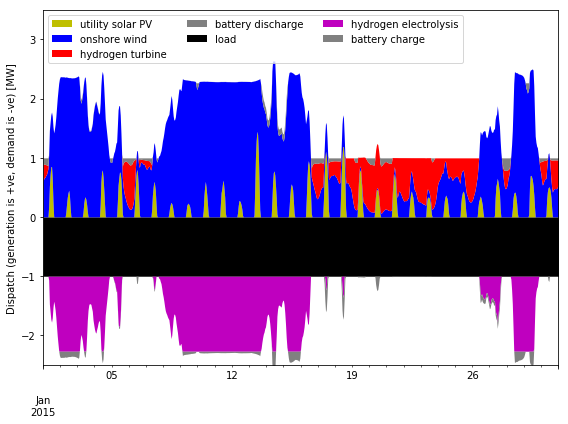

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches((8,6))

start = "2015-01-01"

stop = "2015-01-31"

rename = {"wind" : "onshore wind",
          "solar" : "utility solar PV",
          "battery discharge" : "battery discharge",
          "battery charge" : "battery charge",
          "H2 electrolysis" : "hydrogen electrolysis",
          "H2 to power" : "hydrogen turbine"}

rename = {ct + " "+k : v for k,v in rename.items()}

rename[ct] = "load"

colors = {"onshore wind" : "b",
           "utility solar PV" : "y",
           "battery discharge" : "gray",
           "battery charge" : "gray",
           "load" : "k",
           "hydrogen electrolysis" : "m",
           "hydrogen turbine" : "r"
          }

positive = pd.concat((network.generators_t.p,-network.links_t.p1[[ct+" H2 to power",ct+" battery discharge"]]),axis=1).rename(columns=rename)

negative = pd.concat((-network.loads_t.p,-network.links_t.p0[[ct+" H2 electrolysis",ct+" battery charge"]]),axis=1).rename(columns=rename)

print((abs(positive.sum(axis=1) + negative.sum(axis=1)) > 0.1).any())

positive.loc[start:stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,color=[colors[i] for i in positive.columns])

negative.loc[start:stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,color=[colors[i] for i in negative.columns])

ax.set_ylim([-2.5,3.5])

ax.set_xlim([start,stop])

ax.set_ylabel("Dispatch (generation is +ve, demand is -ve) [MW]")

ax.legend(ncol=3,loc="upper left")

fig.tight_layout()

fig.savefig("img/{}-{}-{}-{}.png".format(ct,scenario,start,stop),dpi=100)

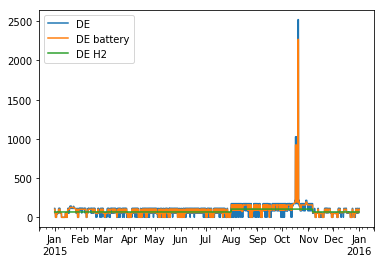

In [18]:
network.buses_t.marginal_price.plot()

In [19]:
network.buses_t.marginal_price.mean()

DE            95.027816
DE battery    93.525105
DE H2         78.074242
dtype: float64

In [47]:
network.links_t.p0.mean()/network.links.p_nom_opt

DE battery charge       0.210566
DE battery discharge    0.170559
DE H2 electrolysis      0.301910
DE H2 to power          0.229704
dtype: float64

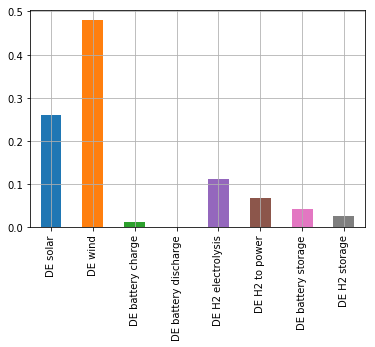

In [20]:
opt_costs = pd.Series()


opt_costs = pd.concat((opt_costs,network.generators.capital_cost*network.generators.p_nom_opt))

opt_costs = pd.concat((opt_costs,network.links.capital_cost*network.links.p_nom_opt))

opt_costs = pd.concat((opt_costs,network.stores.capital_cost*network.stores.e_nom_opt))


(opt_costs/opt_costs.sum()).plot(kind="bar",grid=True)